# Importation

> **Refactor:** All dataframe creation is now guaranteed to precede visualization.  
> **Timestamp:** 2025-08-10T01:25:30Z


## Table of Contents
- [01-Imports](#01-imports)
- [02-Function Definitions](#02-function-definitions)
- [03-Config](#03-config)
- [04-Data Loading](#04-data-loading)
- [05-DataFrames Build & Transforms](#05-dataframes-build-&-transforms)
- [06-Modeling (Cox PH)](#06-modeling-(cox-ph))
- [07-Visualization](#07-visualization)
- [08-Persistence](#08-persistence)
- [09-Other](#09-other)
- [10-Appendix](#10-appendix)

## 01-Imports
<a id='01-imports'></a>

In [1]:
%pip install --upgrade pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

## 02-Function Definitions
<a id='02-function-definitions'></a>

In [ ]:
def visualize_missing_values_ax(
    df: pd.DataFrame,
    ax,
    title: str = None,
    color: str = "#1f77b4",
    show_zero: bool = False,
    top_k: int = None,
    annotate: bool = True,
):
    """
    Render the % missing for ALL columns into a given matplotlib Axes.
    Returns the sorted missing DataFrame used for plotting.
    """
    # Compute % missing
    missing = df.isnull().sum()
    missing_percent = (100 * missing / len(df)).fillna(0)

    missing_df = (
        pd.DataFrame({"column": missing_percent.index, "missing_percent": missing_percent.values})
        .sort_values("missing_percent", ascending=False)
    )
    if not show_zero:
        missing_df = missing_df[missing_df["missing_percent"] > 0]

    if top_k is not None:
        missing_df = missing_df.head(top_k)

    # If empty, show a friendly message
    if missing_df.empty:
        ax.text(0.5, 0.5, "No missing values", ha="center", va="center", fontsize=11)
        ax.set_axis_off()
        return missing_df

    sns.barplot(
        x="missing_percent",
        y="column",
        data=missing_df,
        color=color,
        orient="h",
        ax=ax,
    )

    ax.set_title(title if title else "Missing Values (%)", pad=10, fontsize=12)
    ax.set_xlabel("Percentage Missing (%)")
    ax.set_ylabel("Column")
    ax.set_xlim(0, 100)

    if annotate:
        for i, (_, row) in enumerate(missing_df.iterrows()):
            x = min(100, row["missing_percent"])  # clip at axis max
            ax.text(x + 1, i, f"{row['missing_percent']:.1f}%", va="center", fontsize=9)

    return missing_df


def visualize_missing_dashboard(
    dfs,
    titles=None,
    ncols: int = 2,
    figsize=(16, 6),
    colors=None,
    show_zero: bool = False,
    top_k: int = None,
    annotate: bool = True,
    tight: bool = True,
):
   
    # Normalize inputs
    if isinstance(dfs, dict):
        items = list(dfs.items())  # [(title, df), ...]
    else:
        dfs = list(dfs)
        if titles is None:
            titles = [f"DF {i+1}" for i in range(len(dfs))]
        items = list(zip(titles, dfs))

    n = len(items)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    results = {}

    for idx, (title, df) in enumerate(items):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        color = (colors[idx] if colors and idx < len(colors) else "#1f77b4")

        missing_df = visualize_missing_values_ax(
            df=df,
            ax=ax,
            title=title,
            color=color,
            show_zero=show_zero,
            top_k=top_k,
            annotate=annotate,
        )
        results[title] = missing_df

    # Remove any unused axes
    for idx in range(n, nrows * ncols):
        r, c = divmod(idx, ncols)
        axes[r][c].set_visible(False)

    if tight:
        plt.tight_layout()

    return results


In [4]:

def enrich_client_data(client, employe, direction, groupe):
    # Work on copies to avoid modifying original DataFrames
    client = client.copy()
    employe = employe.copy()
    direction = direction.copy()
    groupe = groupe.copy()

    # Ensure correct types
    direction["ID"] = direction["ID"].astype("object")
    client["ID_BCT"] = client["ID_BCT"].astype("object")
    groupe["ID_BCT"] = groupe["ID_BCT"].astype("object")

    # Merge POLE + LIBELLE from direction into employe
    employe = employe.merge(
        direction[["ID", "POLE", "LIBELLE"]],
        left_on="DIRECTION",
        right_on="ID",
        how="left",
        validate="m:1"
    )

    # Create normalized numeric key for MATRICULE_CHARGE
    client["MATRICULE_CHARGE_key"] = (
        pd.to_numeric(client["MATRICULE_CHARGE"], errors="coerce").astype("Int64")
    )
    employe["MATRICULE_CHARGE_key"] = (
        pd.to_numeric(employe["MATRICULE_CHARGE"], errors="coerce").astype("Int64")
    )

    # Merge employee info into client
    cols_to_add = ["DIRECTION", "NOM", "PRENOM", "POLE", "LIBELLE"]
    client_enriched = client.merge(
        employe[["MATRICULE_CHARGE_key"] + cols_to_add],
        on="MATRICULE_CHARGE_key",
        how="left",
        validate="m:1"
    )

    # Normalize ID_BCT key for both DataFrames
    client_enriched["ID_BCT_key"] = client_enriched["ID_BCT"].astype(str).str.strip().str.upper()
    groupe["ID_BCT_key"] = groupe["ID_BCT"].astype(str).str.strip().str.upper()

    # Merge NOM from groupe into client
    client_enriched = client_enriched.merge(
        groupe[["ID_BCT_key", "NOM"]],
        on="ID_BCT_key",
        how="left",
        validate="m:1"
    )

    # Drop unnecessary columns
    client_enriched = client_enriched.drop(
        columns=["RC","CTX","ACTIVITE", "SS_ACTIVITE", "PP", "POLE_x","POLE_y", "ID_BCT_key", "MATRICULE_CHARGE_key","RAISON_SOCIALE"],
        errors="ignore"
    )

    # Rename columns for clarity
    client_enriched = client_enriched.rename(
        columns={
            "NOM_x": "NOM_EMPLOYE",
            "PRENOM": "PRENOM_EMPLOYE",
            "NOM_y": "NOM_GROUPE"
        }
    )

    return client_enriched


In [ ]:
def attach_client_attributes(df_client: pd.DataFrame, client_enriched: pd.DataFrame) -> pd.DataFrame:
   

    # Work on copies
    tx = df_client.copy()
    ce = client_enriched.copy()

    # Normalize join keys as strings (strip + upper to derisk whitespace/casing drift)
    tx["CLIENT_ID_key"] = tx["CLIENT_ID"].astype(str).str.strip().str.upper()
    ce["ID_key"] = ce["ID"].astype(str).str.strip().str.upper()

    # De-duplicate client table on key
    ce = ce.drop_duplicates(subset=["ID_key"], keep="first")

    # Columns to bring from client_enriched (everything except the join keys)
    client_cols = [
        "ID", "RAISON_SOCIALE", "ID_BCT", "MATRICULE_CHARGE", "SEGMENTS", "AJOUTE_LE",
        "RC", "CTX", "DIRECTION", "NOM_EMPLOYE", "PRENOM_EMPLOYE", "POLE",
        "LIBELLE", "NOM_GROUPE"
    ]

    # Limit to available columns (robustness)
    client_cols = [c for c in client_cols if c in ce.columns]

    # Handle name collisions: if a column already exists in tx, suffix the client version
    collisions = set(client_cols).intersection(set(tx.columns))
    renamer = {c: f"{c}_CLIENT" for c in collisions if c != "ID"}  # don't rename ID yet

    ce_renamed = ce[["ID_key"] + client_cols].rename(columns=renamer)

    # Special-case: keep client ID as a separate named column to avoid confusion
    if "ID" in ce_renamed.columns:
        ce_renamed = ce_renamed.rename(columns={"ID": "CLIENT_MASTER_ID"})

    # Merge (m:1)
    df_enriched = tx.merge(
        ce_renamed,
        left_on="CLIENT_ID_key",
        right_on="ID_key",
        how="left",
        validate="m:1"
    )

    # Housekeeping
    df_enriched = df_enriched.drop(columns=["CLIENT_ID_key", "ID_key"], errors="ignore")

    return df_enriched

In [ ]:
def plot_object_columns_pie_dashboard(df, columns=None, top_k=None, figsize=(14, 10)):
   
    # If no columns specified, take all object-type columns
    if columns is None:
        columns = df.select_dtypes(include='object').columns.tolist()
    
    ncols = 2  # number of subplots per row
    nrows = math.ceil(len(columns) / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if len(columns) > 1 else [axes]  # make iterable
    
    for idx, col in enumerate(columns):
        ax = axes[idx]
        counts = df[col].value_counts(dropna=False)
        
        # If limiting to top_k categories
        if top_k and len(counts) > top_k:
            top_counts = counts.iloc[:top_k]
            other_count = counts.iloc[top_k:].sum()
            counts = pd.concat([top_counts, pd.Series({'Other': other_count})])
        
        # Handle case where column is all NaN
        if counts.empty:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue
        
        wedges, texts, autotexts = ax.pie(
            counts,
            labels=counts.index.astype(str),
            autopct='%1.1f%%',
            startangle=90,
            wedgeprops=dict(edgecolor='white')
        )
        
        ax.set_title(f"{col}", fontsize=12)
        ax.axis('equal')  # Equal aspect ratio ensures the pie is a circle
        plt.setp(autotexts, size=8, weight='bold', color="white")
    
    # Hide unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:
def preprocess_banking_data(df):
    
    print("Preprocessing banking transaction data...")
    print(f"Initial data shape: {df.shape}")
    
    # Create a copy to avoid modifying original data
    df_clean = df.copy()
    
    # Ensure BOOKING_DATE is datetime (already converted based on your info)
    if df_clean['BOOKING_DATE'].dtype != 'datetime64[ns]':
        df_clean['BOOKING_DATE'] = pd.to_datetime(df_clean['BOOKING_DATE'])
    
    # Sort by client and date
    df_clean = df_clean.sort_values(['CLIENT_ID', 'BOOKING_DATE'])
    
    # Handle missing values in key columns
    df_clean['AMOUNT_LCY'] = df_clean['AMOUNT_LCY'].fillna(0)
    df_clean['AMOUNT_FCY'] = df_clean['AMOUNT_FCY'].fillna(0)
    
    # Fill categorical missing values
    categorical_cols = ['NATURE_CLIENT', 'CURRENCY', 'SEGMENTS', 'ACTIVITE', 'DIRECTION']
    for col in categorical_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Unknown')
    
    # Fill numerical missing values
    numerical_cols = ['POLE_CLIENT', 'MATRICULE_CHARGE', 'STATUT', 'EXCHANGE_RATE', 
                     'MT_TND', 'MT_DEVISE', 'COURS_MARCHE', 'MARGE_PNDR']
    for col in numerical_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    print(f"Final data shape: {df_clean.shape}")
    print(f"Date range: {df_clean['BOOKING_DATE'].min()} to {df_clean['BOOKING_DATE'].max()}")
    print(f"Unique clients: {df_clean['CLIENT_ID'].nunique()}")
    
    return df_clean

## 04-Data Loading
<a id='04-data-loading'></a>

In [2]:
client=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table client.xlsx", sheet_name='Exporter la feuille de calcul')
employe=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table employes.xlsx", sheet_name='Exporter la feuille de calcul')
direction=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table direction.xlsx", sheet_name='Exporter la feuille de calcul')
groupe=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table groupe.xlsx", sheet_name='Exporter la feuille de calcul')

In [3]:
#negoci 2021
negoci_2021_1_1=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table ngoci - 2021 1 1.xlsx", sheet_name='Exporter la feuille de calcul')
negoci_2021_1_2=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table ngoci - 2021 1 2.xlsx", sheet_name='Feuil1')
#negoci 2022
negoci_2022_1=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table négocié - 2022 partie 1.xlsx", sheet_name='Exporter la feuille de calcul')
negoci_2022_2=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table négocié - 2022 partie 2.xlsx", sheet_name='Feuil1')
negoci_2022_3=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table négocié - 2022 partie 3.xlsx", sheet_name='Feuil1')
#negoci 2023
negoci_2023_1=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table négocié - 2023 - 1.xlsx", sheet_name='Exporter la feuille de calcul')
negoci_2023_2=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table négocié - 2023 - 2.xlsx", sheet_name='Feuil1')
#confi 2021
confi_2021=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table confi - 2021.xlsx", sheet_name='Feuil1')
#confi 2022
confi_2022=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table confié - 2022.xlsx", sheet_name='Feuil1')
#confi 2023
confi_2023_1_1=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table confi - 2023 1 1.xlsx", sheet_name='Exporter la feuille de calcul')
confi_2023_1_2=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table confi - 2023 1 2.xlsx", sheet_name='Exporter la feuille de calcul')
confi_2023_3=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table confi - 2023 3.xlsx", sheet_name='Exporter la feuille de calcul')
confi_2023_4=pd.read_excel(r"C:\Users\someb\Downloads\Stage\data\table confi - 2023 4.xlsx", sheet_name='Exporter la feuille de calcul')

## 05-DataFrames Build & Transforms
<a id='05-dataframes-build-&-transforms'></a>

In [8]:
print("client:")
print("number of rows:", len(client), "columns :",client.columns.tolist())

print("employe:")
print("number of rows:", len(employe), "columns :",employe.columns.tolist())

print("groupe:")
print("number of rows:", len(groupe), "columns :",groupe.columns.tolist())

print("direction:")
print("number of rows:", len(direction), "columns :",direction.columns.tolist())

client:
number of rows: 1982 columns : ['ID', 'RAISON_SOCIALE', 'ID_BCT', 'MATRICULE_CHARGE', 'ACTIVITE', 'SS_ACTIVITE', 'PP', 'SEGMENTS', 'AJOUTE_LE', 'POLE', 'RC', 'CTX']
employe:
number of rows: 54 columns : ['MATRICULE_CHARGE', 'MATRICULE_T24', 'PRENOM', 'NOM', 'DIRECTION', 'PROFIL', 'STATUT']
groupe:
number of rows: 450 columns : ['ID', 'ID_BCT', 'NOM', 'CHARGE', 'AJOUTE_LE', 'PARTIE_LIEE']
direction:
number of rows: 10 columns : ['ID', 'LIBELLE', 'POLE', 'SHORT_NAME']


In [9]:
confi=[confi_2021, confi_2022, confi_2023_1_1, confi_2023_1_2, confi_2023_3, confi_2023_4]
negoci=[negoci_2021_1_1, negoci_2021_1_2, negoci_2022_1, negoci_2022_2, negoci_2022_3, negoci_2023_1, negoci_2023_2]

In [10]:
for df in confi:
    df.dropna(how='all', inplace=True)

for df in negoci:
    df.dropna(how='all', inplace=True)


In [11]:
confi = pd.concat(
    [confi_2021, confi_2022, confi_2023_1_1, confi_2023_1_2, confi_2023_3, confi_2023_4],
    ignore_index=True
)
negoci = pd.concat(
    [negoci_2021_1_1, negoci_2021_1_2, negoci_2022_1, negoci_2022_2, negoci_2022_3, negoci_2023_1, negoci_2023_2],
    ignore_index=True
)

In [12]:
print("confi:")
print("number of rows:", len(confi), "columns :",confi.columns.tolist())

print("negoci:")
print("number of rows:", len(negoci), "columns :",negoci.columns.tolist())

confi:
number of rows: 182668 columns : ['REFERENCE_OPERATION_T24', 'BOOKING_DATE', 'DD', 'DESCRIPTION_OPERATION', 'ACCOUNT_NUMBER', 'EXCHANGE_RATE', 'AMOUNT_FCY', 'AMOUNT_FCY.1', 'SENS', 'COMPANY_CODE', 'AMOUNT_LCY', 'AMOUNT_LCY.1', 'TRANSACTION_CODE', 'CURRENCY', 'CUSTOMER_ID', 'INPUTTER', 'CHAPITRE_CTOS', 'DEALER_DESK', 'MT_TND', 'MT_DEVISE', 'CLIENT_ID', 'POLE', 'COURS_MARCHE', 'MARGE', 'MARGE_PNDR', 'NATURE_CLIENT']
negoci:
number of rows: 366315 columns : ['REFERENCE_OPERATION_T24', 'ID_CUSTOMER', 'TRADER', 'BOOKING_DATE', 'DD', 'DESCRIPTION_OPERATION', 'ACCOUNT_NUMBER', 'EXCHANGE_RATE', 'AMOUNT_FCY', 'SENS', 'COMPANY_CODE', 'AMOUNT_LCY', 'TRANSACTION_CODE', 'CURRENCY', 'CUSTOMER_ID', 'INPUTTER', 'CHAPITRE_CTOS', 'DEALER_DESK', 'MT_TND', 'MT_DEVISE', 'A_ANNULER', 'POLE', 'REVERSE', 'DEAL_TYPE', 'COURS_MARCHE', 'MARGE_PNDR', 'NATURE_CLIENT', 'MATRICULE_TRADER']


In [14]:
negoci.rename(columns={'ID_CUSTOMER': 'CLIENT_ID'}, inplace=True)

In [15]:
print("Number of rows in confi before cleaning duplicates:", len(confi))
print("Number of rows in negoci before cleaning duplicates:", len(negoci))

confi = confi.drop_duplicates(keep='first').reset_index(drop=True)
negoci = negoci.drop_duplicates(keep='first').reset_index(drop=True)

print("Number of rows in confi before cleaning duplicates:", len(confi))
print("Number of rows in negoci before cleaning duplicates:", len(negoci))

Number of rows in confi before cleaning duplicates: 182668
Number of rows in negoci before cleaning duplicates: 366315
Number of rows in confi before cleaning duplicates: 182155
Number of rows in negoci before cleaning duplicates: 365064


In [16]:
columns_to_keep = ['REFERENCE_OPERATION_T24','CLIENT_ID', 'BOOKING_DATE', 'DESCRIPTION_OPERATION', 'EXCHANGE_RATE', 'AMOUNT_FCY', 'AMOUNT_LCY', 'SENS', 'CURRENCY', 'MT_TND', 'MT_DEVISE', 'COURS_MARCHE', 'NATURE_CLIENT','MARGE_PNDR']
# 2) Create a new DataFrame with only those columns
negoci_final = confi[columns_to_keep].copy()
confi_final = negoci[columns_to_keep].copy()

In [17]:
merged_df = pd.concat(
    [negoci_final, confi_final],
    axis=0,
    ignore_index=True,
    sort=False
)

In [18]:
df_client = merged_df[merged_df["CLIENT_ID"].isin(client["ID"])]


In [19]:
client_enriched = enrich_client_data(client, employe, direction, groupe)


In [20]:
data = attach_client_attributes(df_client, client_enriched)

## 07-Visualization
<a id='07-visualization'></a>

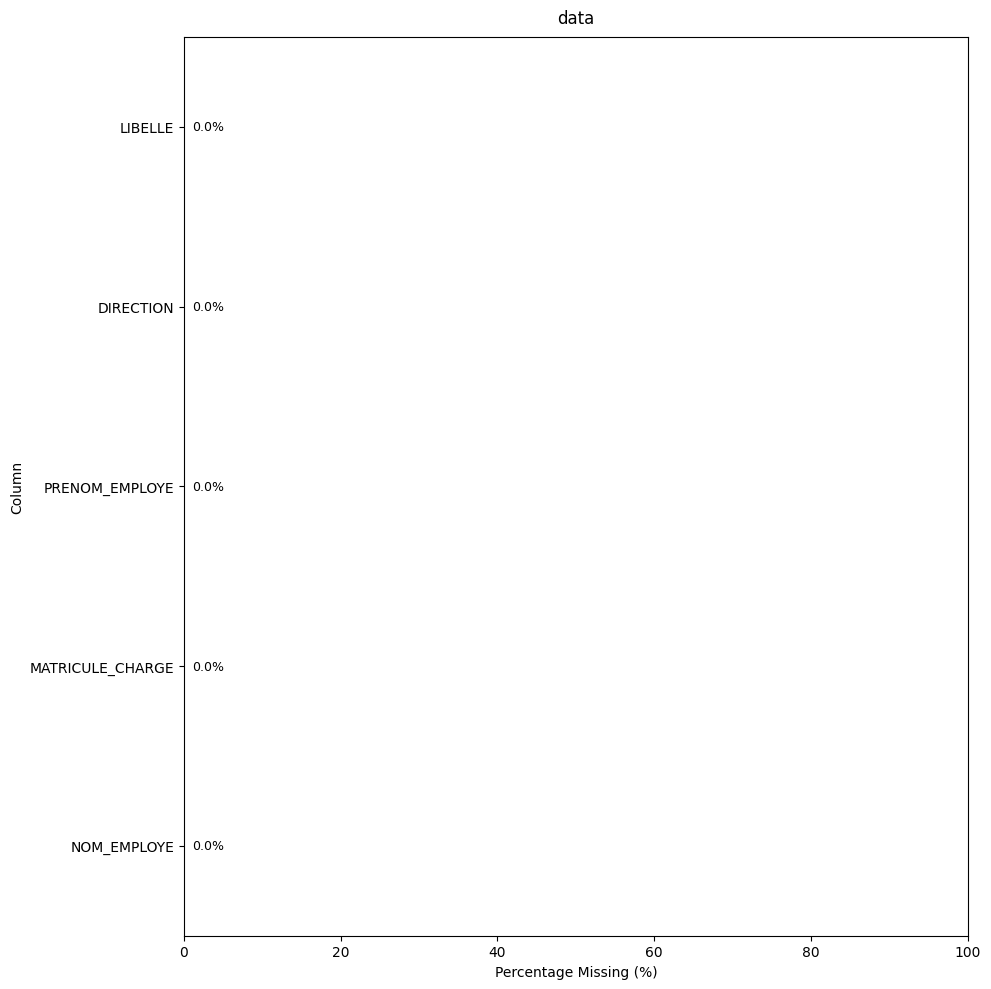

In [21]:
dash = visualize_missing_dashboard(
    {
        "data": data
    },
    ncols=2,
    figsize=(18, 10),
    top_k=20,          
    show_zero=False,    
    annotate=True
)

C:\Users\someb\AppData\Local\Temp\ipykernel_21116\3503158370.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(freq="M"))["REFERENCE_OPERATION_T24"]


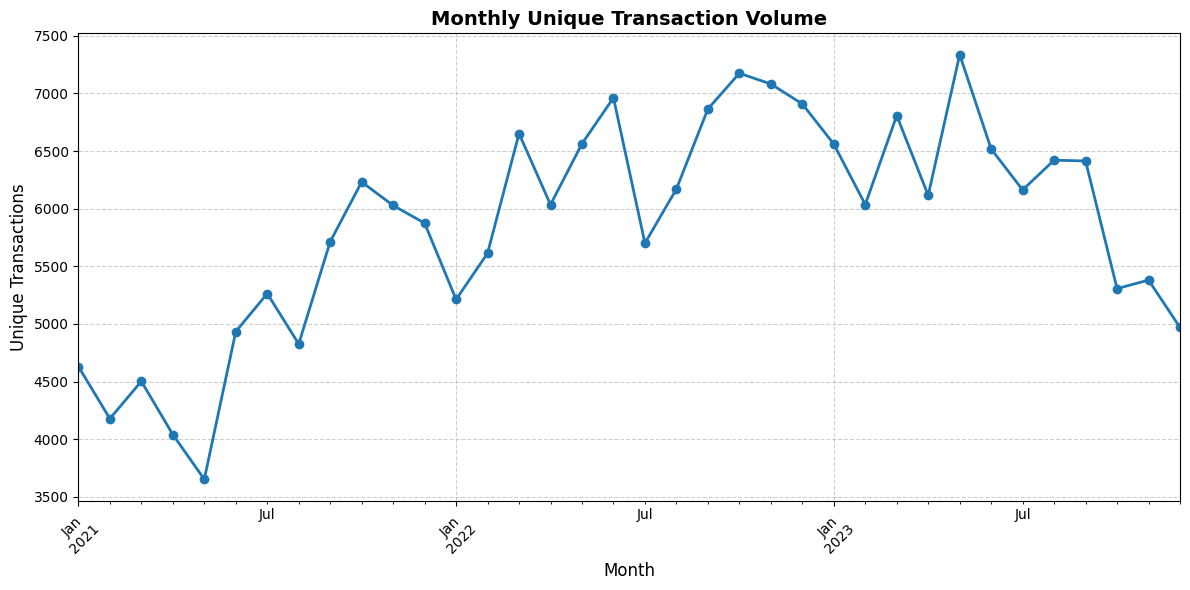

In [22]:
monthly_txn_counts = (
    data
    .set_index("BOOKING_DATE")
    .groupby(pd.Grouper(freq="M"))["REFERENCE_OPERATION_T24"]
    .nunique()
    .rename("unique_txn_count")
)
plt.figure(figsize=(12, 6))
monthly_txn_counts.plot(marker="o", linestyle="-", linewidth=2)
plt.title("Monthly Unique Transaction Volume", fontsize=14, weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Unique Transactions", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346448 entries, 0 to 346447
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   REFERENCE_OPERATION_T24  346448 non-null  object        
 1   CLIENT_ID                346448 non-null  object        
 2   BOOKING_DATE             346448 non-null  datetime64[ns]
 3   DESCRIPTION_OPERATION    346448 non-null  object        
 4   EXCHANGE_RATE            346448 non-null  float64       
 5   AMOUNT_FCY               346448 non-null  float64       
 6   AMOUNT_LCY               346448 non-null  float64       
 7   SENS                     346448 non-null  object        
 8   CURRENCY                 346448 non-null  object        
 9   MT_TND                   346448 non-null  float64       
 10  MT_DEVISE                346448 non-null  float64       
 11  COURS_MARCHE             346448 non-null  float64       
 12  NATURE_CLIENT   

In [24]:
data.columns.tolist()

['REFERENCE_OPERATION_T24',
 'CLIENT_ID',
 'BOOKING_DATE',
 'DESCRIPTION_OPERATION',
 'EXCHANGE_RATE',
 'AMOUNT_FCY',
 'AMOUNT_LCY',
 'SENS',
 'CURRENCY',
 'MT_TND',
 'MT_DEVISE',
 'COURS_MARCHE',
 'NATURE_CLIENT',
 'MARGE_PNDR',
 'CLIENT_MASTER_ID',
 'ID_BCT',
 'MATRICULE_CHARGE',
 'SEGMENTS',
 'AJOUTE_LE',
 'DIRECTION',
 'NOM_EMPLOYE',
 'PRENOM_EMPLOYE',
 'LIBELLE',
 'NOM_GROUPE']

In [25]:
data = data.drop(
        columns=["LIBELLE","NOM_EMPLOYE","PRENOM_EMPLOYE", "ID_BCT", "CLIENT_MASTER_ID"],
        errors="ignore"
    )

In [26]:
min_date = data['BOOKING_DATE'].min()
max_date = data['BOOKING_DATE'].max()
print(f"Date span → from {min_date.date()} to {max_date.date()}")


Date span → from 2021-01-04 to 2023-12-29


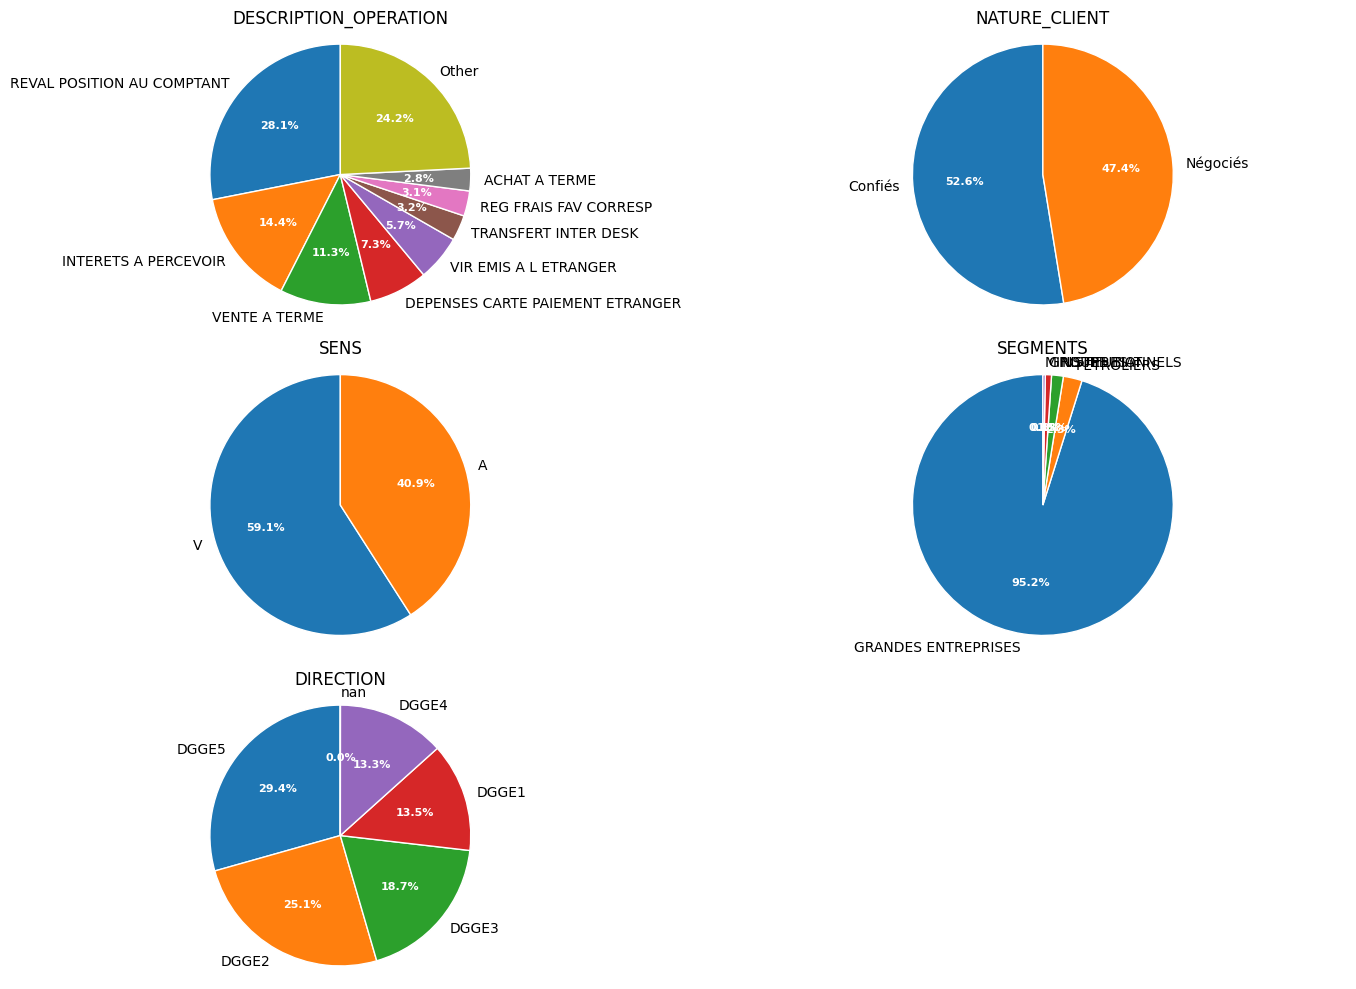

In [27]:
plot_object_columns_pie_dashboard(
    df=data,
    columns=["DESCRIPTION_OPERATION", "NATURE_CLIENT", "SENS","SEGMENTS","DIRECTION"],
    top_k=8
)

In [28]:
df=preprocess_banking_data(data)

Preprocessing banking transaction data...
Initial data shape: (346448, 19)
Final data shape: (346448, 19)
Date range: 2021-01-04 00:00:00 to 2023-12-29 00:00:00
Unique clients: 1000


In [29]:
df = df.sort_values("BOOKING_DATE").reset_index(drop=True)
df.to_csv("final_preprocessed_biat_data.csv", index=False)


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346448 entries, 0 to 346447
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   REFERENCE_OPERATION_T24  346448 non-null  object        
 1   CLIENT_ID                346448 non-null  object        
 2   BOOKING_DATE             346448 non-null  datetime64[ns]
 3   DESCRIPTION_OPERATION    346448 non-null  object        
 4   EXCHANGE_RATE            346448 non-null  float64       
 5   AMOUNT_FCY               346448 non-null  float64       
 6   AMOUNT_LCY               346448 non-null  float64       
 7   SENS                     346448 non-null  object        
 8   CURRENCY                 346448 non-null  object        
 9   MT_TND                   346448 non-null  float64       
 10  MT_DEVISE                346448 non-null  float64       
 11  COURS_MARCHE             346448 non-null  float64       
 12  NATURE_CLIENT   

In [31]:
df.isna().sum()

REFERENCE_OPERATION_T24    0
CLIENT_ID                  0
BOOKING_DATE               0
DESCRIPTION_OPERATION      0
EXCHANGE_RATE              0
AMOUNT_FCY                 0
AMOUNT_LCY                 0
SENS                       0
CURRENCY                   0
MT_TND                     0
MT_DEVISE                  0
COURS_MARCHE               0
NATURE_CLIENT              0
MARGE_PNDR                 0
MATRICULE_CHARGE           0
SEGMENTS                   0
AJOUTE_LE                  0
DIRECTION                  0
NOM_GROUPE                 0
dtype: int64